# Comparison of optimization methods on the complex Stiefel manifold
One can open this tutorial in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/LuchnikovI/QGOpt/tree/master/docs/source/quick_start.ipynb)

In the given tutorial, we compare different first-order Riemannian optimization methods on the complex Stiefel manifold. We consider a toy example of Hamiltonian renormalization. We use isometric matrices (elements of the complex Stiefel manifold) to solve the following problem

$${\rm Tr}\left(V^\dagger H V\right)\rightarrow \min_{V\in \left\{V\in \mathbb{C}^{n\times m}|V^\dagger V = I\right\}}.$$

 In the beginning, let us import some libraries.

In [ ]:
import tensorflow as tf  # tf 2.x
import matplotlib.pyplot as plt
import math

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

# Fix random seed to make results reproducable.
tf.random.set_seed(42)

## Generating of ill conditioned Hamiltonian

In order to compare several optimizers, one needs to consider ill conditioned problem. We generate an ill conditioned Hamiltonian in the following sense: $\log(\lambda_i)\sim {\rm uniform}(-3, 3)$, where $\lambda_i$ is an eigenvalue of a Hamiltonian, ${\rm uniform}(-3, 3)$ is the uniform probability density on the segment $[-3, 3]$. Therefore, a generated Hamiltonian contains eigenvalues of different scales, which makes the standard Riemannian gradient descent inefficient. However, the Riemannian gradient descent with momentum and adaptive optimization methods still can solve the problem fast.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, 'eigval')

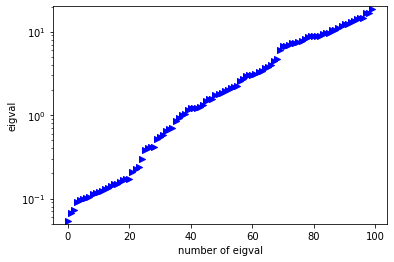

In [ ]:
#============================================================#
ham_dim = 100 # dimension of a Hamiltonian
renorm_ham_dim = 30 # dimension of a renormalized Hamiltonian
#============================================================#

'''One can generate ill conditioned Hamiltonian in two steps:
at first one generates unitary matrix from the eigen decomposition
and then one generates ill conditioned spectrum'''

# First step (QR based random unitary)
'''Here we use real_to_complex function from QGOpt. This function is usefull
when we need to turn to complex representation of a tensor from
its real representation'''
Q = qgo.manifolds.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2),
                                                   dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)

# Second stape (ill conditioned spectrum)
S = tf.random.uniform((ham_dim,), -3, 3)
S = tf.exp(S)
S = tf.cast(S, dtype=tf.complex128)

# A hamiltonian (built from its eigen decomposition)
H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

# Plotting of spectyrum
plt.ylim(top=math.exp(3), bottom=math.exp(-3))
plt.scatter(tf.range(0, H.shape[0]),
            tf.linalg.eigvalsh(H),
            color='blue', marker='>')
plt.yscale('log')
plt.xlabel('number of eigval')
plt.ylabel('eigval')

## Manifold and optimizers
Here we define the complex Stiefel manifold and different optimizers to compare them with each other.

In [ ]:
'''At first, we define the complex Stiefel manifold with different retractions
and metrics'''

#======================= Different retractions and metrics ====================#
m_cayley = qgo.manifolds.StiefelManifold(retraction='cayley')
m_svd = qgo.manifolds.StiefelManifold()
m_cayley_canonical = qgo.manifolds.StiefelManifold(retraction='cayley',
                                                   metric='canonical')
m_svd_canonical = qgo.manifolds.StiefelManifold(metric='canonical')
#==============================================================================#


'''Then we define initial isometric matrix by using method random of
the manifold'''
# initial random isometric matrix
q_in = m_svd.random((ham_dim, renorm_ham_dim), dtype=tf.complex128)
# its real representation
q_in = qgo.manifolds.complex_to_real(q_in)

'''The exact solution of a problem is known and given
by eigen decomposition.'''
min_value = tf.cast(tf.reduce_sum(tf.linalg.eigvalsh(H)[:renorm_ham_dim]),
                    dtype=tf.float64)

'''To compare different optimization methods, retractions and metrics we
define several optimizers and write them into the dict'''
#========================== Different optimizers ==============================#
opts = {
        'GD_cayley':qgo.optimizers.RSGD(m_cayley, 0.003),
        'GD_svd':qgo.optimizers.RSGD(m_svd, 0.003),
        'GD_cayley_with_momentum':qgo.optimizers.RSGD(m_cayley, 0.2, 0.9),
        'GD_svd_with_momentum':qgo.optimizers.RSGD(m_svd, 0.2, 0.9),
        'Adam_cayley':qgo.optimizers.RAdam(m_cayley, 0.8),
        'Adam_svd':qgo.optimizers.RAdam(m_svd, 0.8),
        'Adam_cayley_with_ams':qgo.optimizers.RAdam(m_cayley, 0.8, ams=True),
        'Adam_svd_with_ams':qgo.optimizers.RAdam(m_svd, 0.8, ams=True),
        'GD_cayley_canonical':qgo.optimizers.RSGD(m_cayley_canonical, 0.003),
        'GD_svd__canonical':qgo.optimizers.RSGD(m_svd_canonical, 0.003),
        'GD_cayley_with_momentum_canonical':qgo.optimizers.RSGD(m_cayley_canonical,
                                                                0.2, 0.9),
        'GD_svd_with_momentum_canonical':qgo.optimizers.RSGD(m_svd_canonical,
                                                             0.2, 0.9),
        'Adam_cayley_canonical':qgo.optimizers.RAdam(m_cayley_canonical, 0.8),
        'Adam_svd_canonical':qgo.optimizers.RAdam(m_svd_canonical, 0.8),
        'Adam_cayley_with_ams_canonical':qgo.optimizers.RAdam(m_cayley_canonical,
                                                              0.8, ams=True),
        'Adam_svd_with_ams_canonical':qgo.optimizers.RAdam(m_svd, 0.8, ams=True)
       }
#==============================================================================#

## Optimization loop 
Now we can solve the optimization problem
 $${\rm Tr}\left(V^\dagger H V\right)\rightarrow \min_{V\in \left\{V\in \mathbb{C}^{n\times m}|V^\dagger V = I\right\}},$$ by using different types of Riemannian optimizers.

In [ ]:
#=============================================#
number_of_steps = 1000  # number of iterations
#=============================================#

err_dict = {}  # the dict will be filled by lists of errors

# loop over dict of optimizers
for key, opt in opts.items():
    
    err = []  # will be filled by error vs iter
    q = tf.Variable(q_in)  # turning initial isometry to variable
    
    # optimization loop
    for _ in range(number_of_steps):
        with tf.GradientTape() as tape:
            # turning isometry to its complex representation
            Z = qgo.manifolds.real_to_complex(q)
            # result of renormalization
            loss = tf.cast(tf.linalg.trace((tf.linalg.adjoint(Z) @ H @ Z)),
                        dtype=tf.float64)
            # add value of error to the list of errors
            err.append(loss - min_value)
        grad = tape.gradient(loss, q)  # gradient

        # optimization step (the same as in pure TensorFlow)
        opt.apply_gradients(zip([grad], [q]))

    # add list of errors to the dict
    err_dict[key] = err

## Plotting value of error vs iteration for each optimizer.

Text(0, 0.5, 'err')

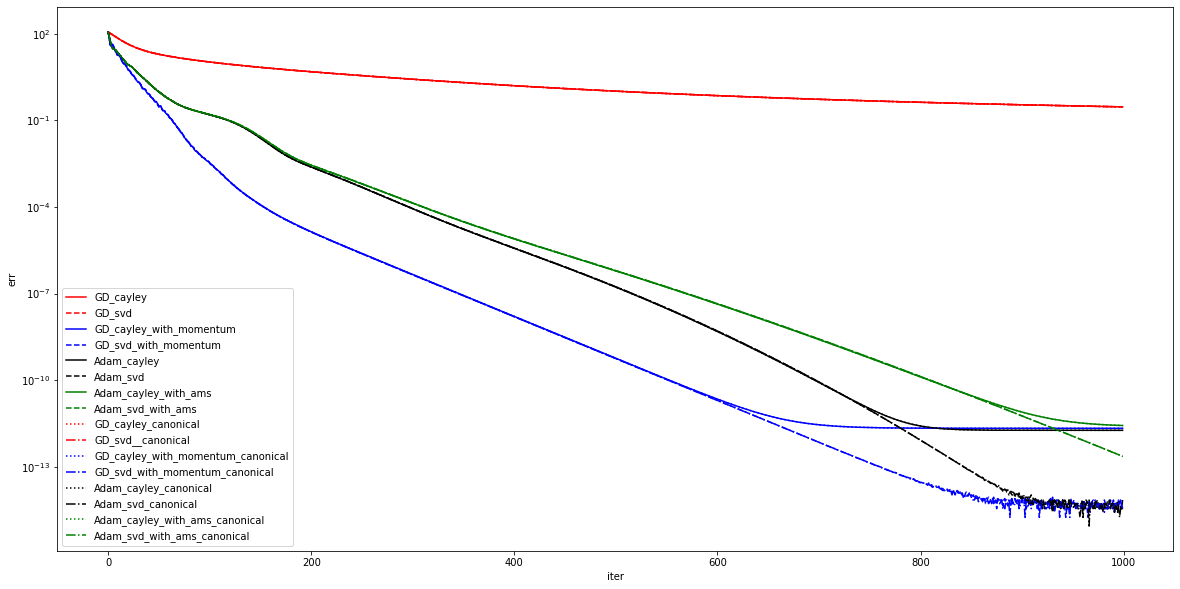

In [ ]:
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--',
          'r:', 'r-.', 'b:', 'b-.', 'k:', 'k-.', 'g:', 'g-.']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(err_dict[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')